# [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Imports and Notebook Utilities
#%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

# def imshow(a, fmt='jpeg'):
#   display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

# def zoom(img, scale=4):
#   img = np.repeat(img, scale, 0)
#   img = np.repeat(img, scale, 1)
#   return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-05a04abb-92a3-1b14-d904-4cff921a0220)


In [2]:
import torch
import torchvision.models as models

if torch.cuda.is_available():
    print('Using GPU/CUDA.')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print('Not using GPU/CUDA, using CPU.')

Using GPU/CUDA.


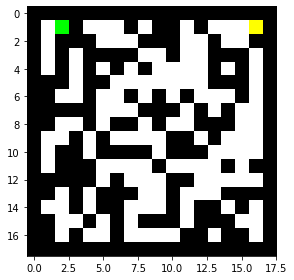

In [11]:
#@title Target image {vertical-output: true}
np.set_printoptions(threshold=sys.maxsize)

empty_chan = 0
wall_chan = 1
src_chan = 2
trg_chan = 3
path_chan = 4

def generate_random_maze(render=True):
    batch_size = 1
    width = 16

    # Generate empty room with with borders.
    rand_maze_onehot = torch.zeros((batch_size, 4, width + 2, width + 2), dtype=int)
    rand_maze_onehot[:, wall_chan, [0, -1], :] = 1
    rand_maze_onehot[:, wall_chan, :, [0, -1]] = 1

    # Randomly generate wall/empty tiles.
    rand_walls = torch.randint(0, 2, (batch_size, 1, width, width))
    rand_maze_onehot[:, wall_chan: wall_chan + 1, 1: -1, 1: -1] = rand_walls
    rand_maze_onehot[:, empty_chan: empty_chan + 1, 1: -1, 1: -1] = (rand_walls == 0).int()

    # Randomly generate sources/targets.
    src_xs, src_ys, trg_xs, trg_ys = torch.randint(0, width, (4, batch_size)) + 1

    # Remove wall/empty tiles at location of source/target.
    rand_maze_onehot[torch.arange(batch_size), empty_chan, src_xs, src_ys] = 0
    rand_maze_onehot[torch.arange(batch_size), wall_chan, src_xs, src_ys] = 0
    rand_maze_onehot[torch.arange(batch_size), empty_chan, trg_xs, trg_ys] = 0
    rand_maze_onehot[torch.arange(batch_size), wall_chan, trg_xs, trg_ys] = 0

    # Add sources and targets.
    rand_maze_onehot[torch.arange(batch_size), src_chan, src_xs, src_ys] = 1
    rand_maze_onehot[torch.arange(batch_size), trg_chan, trg_xs, trg_ys] = 1

    return rand_maze_onehot

empty_color = torch.Tensor([1.0, 1.0, 1.0])
wall_color = torch.Tensor([0.0, 0.0, 0.0])
src_color = torch.Tensor([1.0, 1.0, 0.0])
trg_color = torch.Tensor([0.0, 1.0, 0.0])
path_color = torch.Tensor([1.0, 0.0, 0.0])
colors = {empty_chan: empty_color, wall_chan: wall_color, path_chan: path_color, src_chan: src_color, trg_chan: trg_color, }


def render_discrete(arr, colors=colors):
    batch_size, height, width = arr.shape
    im = torch.zeros((batch_size, height, width, 3), dtype=torch.float32)

    for chan, color in colors.items():
        idxs = torch.where(arr == chan)
        im[idxs[0], idxs[1], idxs[2], :] = color

    im = im.cpu().numpy()

    return im


rand_maze_onehot = generate_random_maze()
rand_maze_im = render_discrete(rand_maze_onehot.argmax(dim=1))
fig, ax = pl.subplots()
ax.imshow(np.hstack(rand_maze_im), )
pl.tight_layout()

Generated 2 random mazes.
Solution length: 3


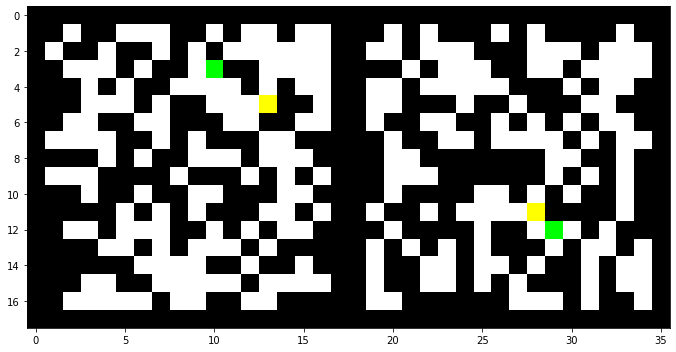

In [260]:
adj_coords_2d = np.array([
    [1, 0],
    [0, 1],
    [-1, 0],
    [0, -1]
])

def bfs(arr, passable=0, impassable=1, src=2, trg=3):
    width = arr.shape[0]
    assert width == arr.shape[1]
    srcs = np.argwhere(arr == src)
    assert srcs.shape[0] == 1
    src = tuple(srcs[0])
    frontier = [src]
    back_paths = {}
    visited = set({})
    while frontier:
        curr = frontier.pop(0)
        if arr[curr[0], curr[1]] == trg:
            path = []
            path.append(curr)
            while curr in back_paths:
                curr = back_paths[curr]
                path.append(curr)
            return path[::-1]
        visited.add(curr)
        adjs = [tuple((np.array(curr) + move) % width) for move in adj_coords_2d]
        for adj in adjs:
            if adj in visited or arr[adj[0], adj[1]] == impassable:
                continue
            frontier.append(adj)
            back_paths.update({adj: curr})
    return []

data_n = 2
solvable_mazes_onehot = []
solvable_mazes_discrete = []

# Generate new random mazes until we get enough solvable ones.
i = 0
while len(solvable_mazes_onehot) < data_n:
    rand_maze_onehot = generate_random_maze()
    rand_maze_discrete = rand_maze_onehot.argmax(axis=1)
    sol = bfs(rand_maze_discrete[0].cpu().numpy())
    if sol:
        solvable_mazes_onehot.append(rand_maze_onehot)
        solvable_mazes_discrete.append(rand_maze_discrete)
    i += 1

print(f'Generated {i} random mazes.')

rand_maze_ims = [render_discrete(rand_maze_discrete)[0] for rand_maze_discrete in solvable_mazes_discrete]
fig, ax = pl.subplots(figsize=(20, 5))
pl.imshow(np.hstack(rand_maze_ims))
pl.tight_layout()
print(f'Solution length: {len(sol)}')

<generator object <genexpr> at 0x7f89719f2200>


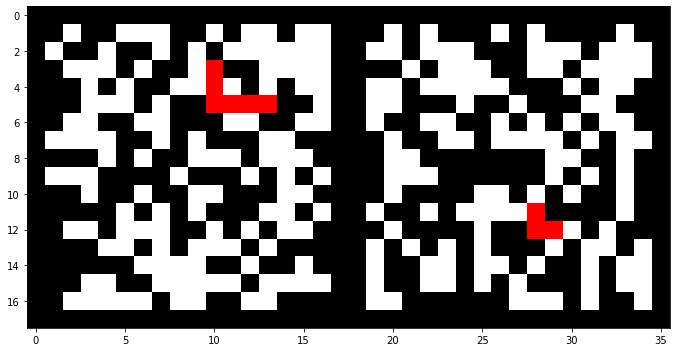

In [261]:
path_chan = 4
solved_mazes = [maze_discrete.clone() for maze_discrete in solvable_mazes_discrete]

for solved_maze in solved_mazes:
    sol = bfs(solved_maze[0].cpu().numpy())
    for x, y in sol:
        # if rand_maze_discrete_i[x, y] not in [src_chan, trg_chan]:
            # assert rand_maze_discrete_i[x, y] == empty_chan
        solved_maze[0, x, y] = path_chan

solved_maze_ims = [render_discrete(solved_maze)[0] for solved_maze in solved_mazes]
print(solved_maze.shape for solved_maze in solved_maze_ims)
fig, ax = pl.subplots(figsize=(20, 5))
pl.imshow(np.hstack(solved_maze_ims))
pl.tight_layout()

2
torch.Size([1, 18, 18])
torch.Size([2, 18, 18])
tensor(-1.) tensor(1.)


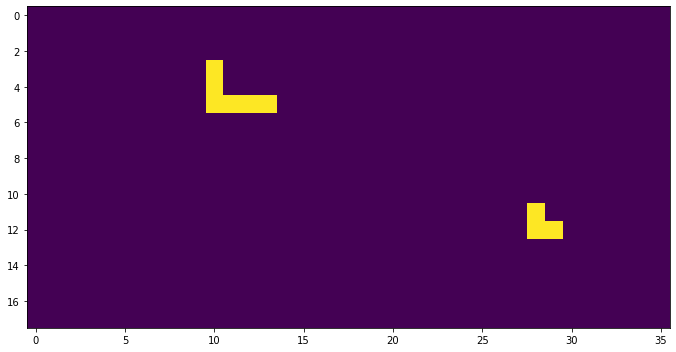

In [262]:
print(len(solved_mazes))
print(solved_mazes[0].shape)
path_targets = torch.vstack([(solved_maze == path_chan).float() for solved_maze in solved_mazes])
print(path_targets.shape)

# Scale the path target so that, assuming the network outputs 0 everywhere, not producing the target path results in as
# much loss as putting path tiles in the wrong locations.
# n_path_tiles = path_target.sum()
# path_scaling = path_target.numel() / n_path_tiles
path_targets[torch.where(path_targets == 0)] = -1.0
print(path_targets.min(), path_targets.max())

fig, ax = pl.subplots(figsize=(20, 5))
pl.imshow(np.hstack(path_targets.cpu()))
pl.tight_layout()

In [275]:
#@title Minimalistic Neural CA
# ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
# sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
# lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# def perchannel_conv(x, filters):
#   '''filters: [filter_n, h, w]'''
#   b, ch, h, w = x.shape
#   y = x.reshape(b*ch, 1, h, w)
#   y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
#   y = torch.nn.functional.conv2d(y, filters[:,None])
#   return y.reshape(b, -1, h, w)

# def perception(x):
#   filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
#   return perchannel_conv(x, filters)

n_chan = 48

class CA(torch.nn.Module):
  def __init__(self, chn=n_chan, hidden_n=96):
    super().__init__()
    self.chn = chn
    # self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1)
    self.w1 = torch.nn.Conv2d(chn, hidden_n, 3, padding=1, padding_mode='circular')
    self.w2 = torch.nn.Conv2d(hidden_n, n_chan, 1)
    # self.w3 = torch.nn.Conv2d(hidden_n, n_chan, 1)
    # self.w2.weight.data.zero_()

    # The initial/actual state of the board (so that we can use walls to simulate path-flood).
    self.x0 = None

  def forward(self, x, update_rate=0.5):
    # y = perception(x)
    y = x
    if self.x0 is None:
      y = self.x0 = x
    else:
      y = x + self.x0
    y = self.w2(torch.relu(self.w1(y)))
    # y = torch.relu(y)
    # y = self.w3(y)
    y = (torch.sigmoid(y) - 0.5) * 2
    b, c, h, w = y.shape
    # return x + y
    return y
    # udpate_mask = (torch.rand(b, 1, h, w)+update_rate).floor()
    # return x+y*udpate_mask
    # return y*udpate_mask

  def seed(self, n, sz=16):
    return torch.zeros(n, self.chn, sz, sz)

  def reset(self, x0):
    self.x0 = x0

# def to_rgb(x):
  # return x[...,:3,:,:]+0.5

def to_path(x):
  return x[...,-1:,:,:]

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 46224


In [281]:
#@title setup training
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-4)

lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.01)
loss_log = []
with torch.no_grad():
  pool = ca.seed(256)

path activation min: -0.9999786019325256, max: 0.027852416038513184


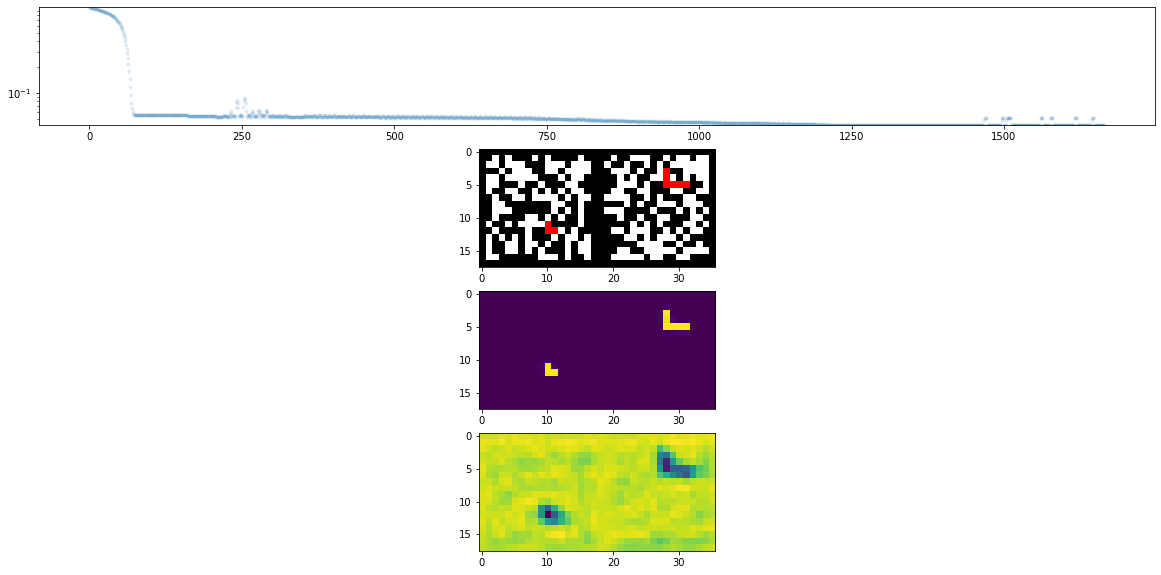

step_n: 1681  loss: 0.041676927357912064  lr: 0.0001

KeyboardInterrupt: 

In [282]:
#@title training loop {vertical-output: true}

# The set of initial mazes (padded with 0s, channel-wise, to act as the initial state of the CA).
training_mazes = torch.vstack(solvable_mazes_onehot)
training_maze_xs = torch.zeros(training_mazes.shape[0], n_chan, training_mazes.shape[2], training_mazes.shape[3])
training_maze_xs[:, :4, :, :] = training_mazes
# pl.imshow(np.hstack(training_maze_xs[...,2:3,:,:].permute([0,2,3,1]).cpu()))
# sys.exit()

# A set of mazes-in-progress, which will allow us to effectively run episodes up to length m * step_m (where m is some 
# integer), while computing loss against optimal path and updating weights every step_n-many steps.
pool = training_maze_xs.clone()

# Images of solved mazes, for reference.
solved_maze_ims = torch.Tensor(solved_maze_ims)

# Upper bound of net steps = step_n * m. Expected net steps = (minibatch_size / data_n) * m * step_n. (Since we select from pool
# randomly before each mini-episode.)
minibatch_size = 4  # how many mazes on which to train at once
minibatch_size = min(minibatch_size, data_n)
step_n = 64
expected_net_steps = 64 * 4
m = int(expected_net_steps / step_n * data_n / minibatch_size)

for i in range(8000):
  with torch.no_grad():

    if i % m == 0:
      pool = training_maze_xs.clone()

    # batch_idx = np.random.choice(len(pool), 4, replace=False)
    batch_idx = np.random.choice(pool.shape[0], minibatch_size, replace=False)

    x = pool[batch_idx]
    # x = torch.zeros(x_maze.shape[0], n_chan, x_maze.shape[2], x_maze.shape[3])
    # x[:, :4, :, :] = x_maze
    x0 = training_maze_xs[batch_idx].clone()
    ca.reset(x0)


  # step_n = np.random.randint(32, 96)

  # The following line is equivalent to this code:
  # for k in range(step_n):
    # x = ca(x + x0)
  # It uses gradient checkpointing to save memory, which enables larger
  # batches and longer CA step sequences. Surprisingly, this version
  # is also ~2x faster than a simple loop, even though it performs
  # the forward pass twice!
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)


  # imgs = to_rgb(x)
  paths = to_path(x)
  # styles = calc_styles(imgs)

  # overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  overflow_loss = 0

  # loss = style_loss(styles, target_style)+overflow_loss
  err = paths - path_targets
  # err = 1 - paths
  # path_idxs = torch.where(path_target == 0.0)

  # TODO: support batches
  # err[0, 0, path_idxs[0], path_idxs[1]] *= 0

  # print(err)
  loss = err.square().mean() + overflow_loss
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    # lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())

    if i%64==0:
      clear_output(True)
      fig, ax = pl.subplots(2, 4, figsize=(20, 10))
      pl.subplot(411)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      # imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      paths = to_path(x).permute([0, 2, 3, 1]).cpu()
      # imshow(np.hstack(imgs))
      pl.subplot(412)
      pl.imshow(np.hstack(solved_maze_ims[batch_idx].cpu()))
      pl.subplot(413)
      pl.imshow(np.hstack(paths))  #, vmin=-1.0, vmax=1.0)
      pl.subplot(414)
      pl.imshow(np.hstack(x[...,-2:-1,:,:].permute([0,2,3,1]).cpu()))
      # pl.imshow(np.hstack(ca.x0[...,0:1,:,:].permute([0,2,3,1]).cpu()))
      print(f'path activation min: {paths.min()}, max: {paths.max()}')
      pl.show()

    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')

    # ca.reset()


# print()
# print(paths.min(), paths.max(), path_targets.min(), path_targets.max())

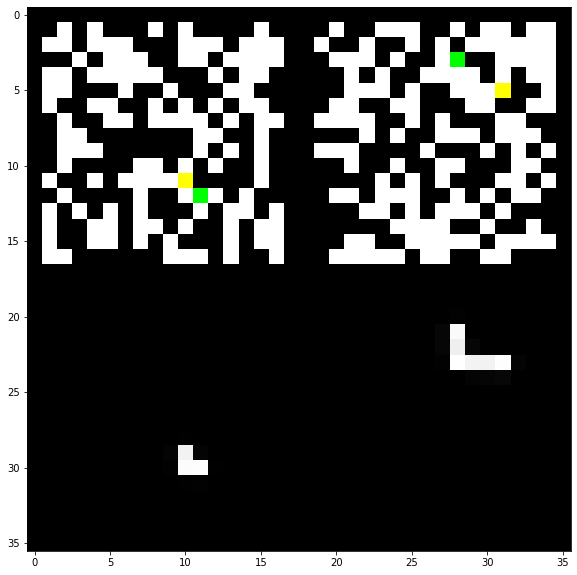

In [283]:
#@title NCA video {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():

  def write(x, x0):
    img = to_path(x).permute(0, 2, 3, 1).cpu()
    # img = (img + 1) / 2
    img = (img - img.min()) / (img.max() - img.min())
    img = np.hstack(img)
    solved_maze_ims = [render_discrete(x0i[None, :4, ...].argmax(1))[0] for x0i in x0]
    solved_mazes_im = np.hstack(solved_maze_ims)
    # imgs = np.vstack([np.tile(img, (1, 1, 3)), np.tile(np.hstack(x0[..., 0:1, :, :].permute(0, 2, 3, 1).cpu()), (1, 1, 3))])
    imgs = np.vstack([solved_mazes_im, np.tile(img, (1, 1, 3))])
    vid.add(imgs)
    fig, ax = pl.subplots(figsize=(10,10))
    pl.imshow(imgs)
    pl.show()

  ca.reset(x0)
  x = x0.clone()
  write(x, x0)
  # for k in tnrange(300, leave=False):
  # for k in range(m):
    # step_n = min(2**(k//30), 16)
  for i in range(expected_net_steps):
    x = ca(x)
    # pl.imshow(x)
    # pl.show()
    write(x, x0)
    if i < expected_net_steps - 1:
      clear_output(True)

In [ ]:
# TODO: test trained model on newly-generated solvable mazes to test inference.